In [1]:
import numpy as np
import scipy.linalg as la
import torch as pt
import scipy.integrate as itg
import cvxpy as cvx
import numpy.random as rnd
from sklearn import mixture
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import timeit
from tqdm import tqdm

import mechsamp as ms
from importlib import reload
%matplotlib inline

In [2]:

    
    
    
    
def makeBasicHamiltonian(loss_fun):
    def H_fun(x):
        n = int(len(x)/2)
        q = x[:n]
        p = x[n:]
        
        return loss_fun(q) + .5 * pt.sum(p**2)
        

    
def hamiltonsEquations(x,H_fun):
    n = int(len(x)/2)

    
    x.grad = pt.zeros_like(x)
    
    H = H_fun(x)
    H.backward()
    
    q_dot = x.grad[n:]
    p_dot = -x.grad[:n]
    
    return pt.cat([q_dot,p_dot])
    

def SOVF(x,lossFun):
    n = int(len(x)/2)
    q = x[:n]
    p = x[n:]
    
    x.grad = pt.zeros_like(x)
    
    f = lossFun(q)
    f.backward()
    g = x.grad[:n]
    
    return pt.cat([p,-(g+p)])
    
def SOLangevinStep(x,lossFun,eta,gamma=1.,A=None,b=None):
    """
    Second-Order Langevin Dynamics
    """
    
    n = int(len(x)/2)
    q = x[:n]
    p = x[n:]
    
    x.grad = pt.zeros_like(x)
    
    f = lossFun(q)
    f.backward()
    q_dot = p
    
    p_dot = -(x.grad[:n]+gamma*p)
    
    q_new = q + eta * q_dot
    p_new = p + eta * q_dot + np.sqrt(2*eta) * pt.randn_like(p)
    x_new = pt.cat([q_new,p_new])
    if A is not None:
        x_new = reflectPolyhedron(x_new,A,b)
        
    x_new = x_new.detach().clone().requires_grad_(True)
    return x_new

def HMCStep(x,H_fun,tstart=0.,T=1.,A=None,b=None):
    t_span = [tstart,tstart+T]
    # First reset the the velocity
    n = int(len(x)/2)
    x = pt.cat([x[:n],pt.randn_like(x[:n])])
    
    def vfScipy(t,y):
        x_pt = pt.tensor(y,dtype=x.dtype,requires_grad=True)
        x_dot_pt = SOVF(x_pt,lossFun)
        return x_dot_pt.detach().numpy()
    
    
    
    def event_fun(t,y):
        n = int(len(y)/2)
        x_pt = pt.tensor(y[:n],dtype=x.dtype)
        max_gap = pt.max(A@x_pt - b)-1e-3
        return max_gap.detach().numpy()
    
    def reflect_fun(y):
        x_pt = pt.tensor(y,dtype=x.dtype)
        x_pt_new = reflectPolyhedron(x_pt,A,b)
        return x_pt_new.detach().numpy()
        
    event_fun.terminal = True
    event_fun.direction = 1
    
    x0 = x.detach().numpy()
    
    finished = False
    
    Time_np_list = []
    X_np_list = []
    
    while not finished:
        sol = itg.solve_ivp(vfScipy,t_span,x0,events = event_fun)
        
        Time_np_list.append(sol.t)
        X_np_list.append(sol.y)
            
        if sol.status == 0:
            finished = True
            
        elif sol.status == 1:
            x0 = reflect_fun(sol.y[:,-1])
            t_span = [sol.t[-1],tstart + T]
            
            
    X_np = np.hstack(X_np_list).T
    Time_np = np.hstack(Time_np_list)
    
    X = pt.tensor(X_np,dtype=x.dtype)
    Time = pt.tensor(Time_np,dtype=x.dtype)
    
    return X,Time
            
    
        
    
    
    
    

100%|██████████| 10000/10000 [00:01<00:00, 5001.96it/s]


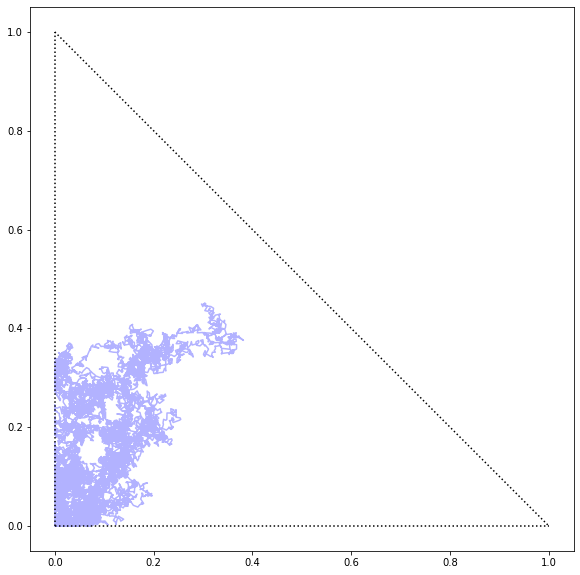

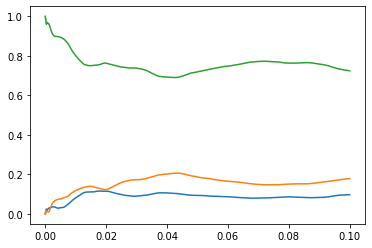

In [3]:
# First-Order Langevin
reload(ms)

A = pt.tensor([[-1.,0],
               [0,-1.],
               [1,1.]])
b = pt.tensor([0.,0.,1.])

zeroLoss = lambda x : pt.dot(pt.zeros_like(x),x)
eta = .00001
foSampler = ms.FOLangevin(zeroLoss,eta,A,b)


NumSteps = int(1e4)

x = pt.randn(2)
x = ms.projectPolyhedron(x,A,b)
x = x.detach().clone().requires_grad_(True)

X = [x]

W = pt.randn(NumSteps,2)



for t in tqdm(range(NumSteps)):
    x = foSampler.step(x)
    X.append(x)
    
X = pt.stack(X)

X_np = X.detach().numpy()
plt.figure(figsize=(10,10))
plt.plot(X_np[:,0],X_np[:,1],'b',alpha=.3)


# Ordered Boundary
#plt.plot([1./3.,1./2.],[1./3.,1./2.],'k:')
#plt.plot([1./2.,1.],[1./2.,0.],'k:')
#plt.plot([1./3.,1.],[1./3.,0.],'k:')

# Unordered Boundary
plt.plot([0,1],[0,0],'k:')
plt.plot([0,0],[0,1],'k:')
plt.plot([0,1],[1,0],'k:')
plt.gca().set_aspect('equal')

plt.figure()
Alpha = np.hstack([X_np,np.reshape(1-X_np.sum(axis=1),(len(X),1))])
Time = eta * np.arange(NumSteps+1)
plt.plot(Time,np.cumsum(Alpha,axis=0)/np.outer(np.arange(1,NumSteps+2),np.ones(3)))

100%|██████████| 10000/10000 [00:04<00:00, 2083.15it/s]


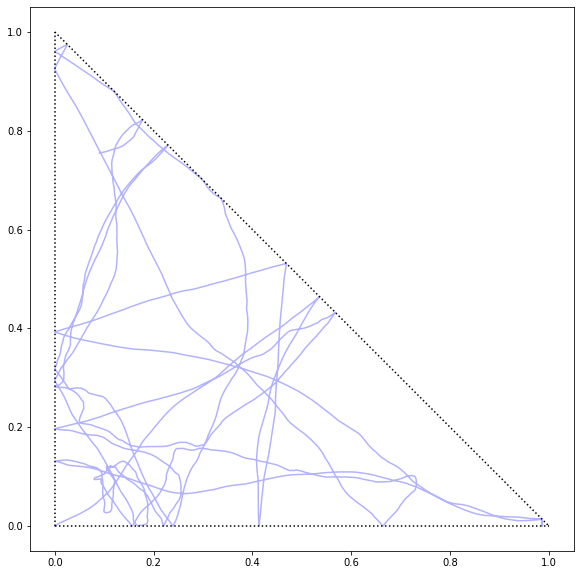

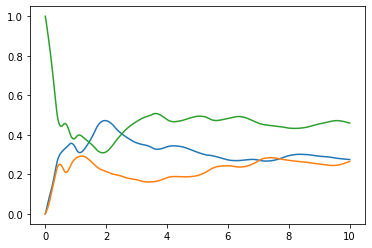

In [4]:
# Second-Order Langevin
reload(ms)
eta = .001
sigma = np.sqrt(2*eta)
NumSteps = int(1e4)

soSampler = ms.SOLangevin(zeroLoss,eta,A=A,b=b)
x = pt.randn(4)
x = ms.reflectPolyhedron(x,A,b)
x = x.detach().clone().requires_grad_(True)

X = [x]

for t in tqdm(range(NumSteps)):
    x = soSampler.step(x)
    X.append(x)
    
X = pt.stack(X)

X_np = X.detach().numpy()
plt.figure(figsize=(10,10))
plt.plot(X_np[:,0],X_np[:,1],'b',alpha=.3)


# Ordered Boundary
#plt.plot([1./3.,1./2.],[1./3.,1./2.],'k:')
#plt.plot([1./2.,1.],[1./2.,0.],'k:')
#plt.plot([1./3.,1.],[1./3.,0.],'k:')

# Unordered Boundary
plt.plot([0,1],[0,0],'k:')
plt.plot([0,0],[0,1],'k:')
plt.plot([0,1],[1,0],'k:')
plt.gca().set_aspect('equal')

plt.figure()
Alpha = np.hstack([X_np[:,:2],np.reshape(1-X_np[:,:2].sum(axis=1),(len(X_np),1))])
Time = eta * np.arange(NumSteps+1)
plt.plot(Time,np.cumsum(Alpha,axis=0)/np.outer(np.arange(1,NumSteps+2),np.ones(3)))

100%|██████████| 100/100 [00:01<00:00, 66.84it/s]


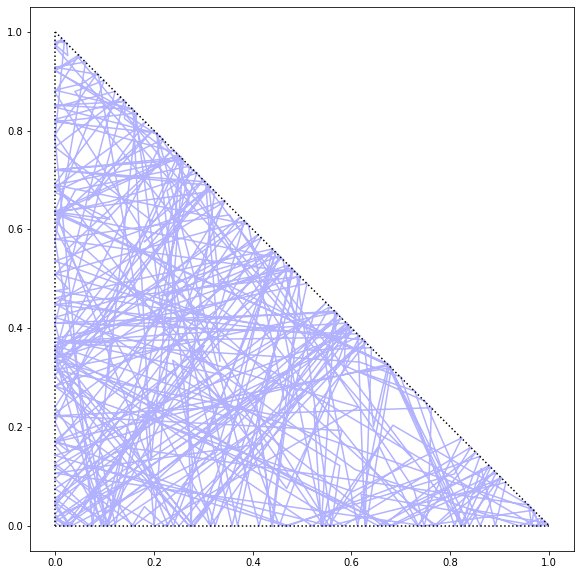

<Figure size 432x288 with 0 Axes>

In [5]:
#HMC
reload(ms)

HMC = ms.HMCSampler(zeroLoss,A,b)
NumSteps = int(100)

x = pt.randn(4)
x = ms.reflectPolyhedron(x,A,b)
x = x.detach().clone().requires_grad_(True)

# Center the state
x_var = cvx.Variable(A.shape[1])

objective = cvx.Minimize(-cvx.sum(cvx.log(b-A@x_var)))
prob = cvx.Problem(objective=objective)
prob.solve()


x_var.value

q = pt.tensor(x_var.value,dtype=pt.float32)
p = pt.randn_like(q)

x = pt.cat([q,p]).detach().clone().requires_grad_(True)

X_list = []
Time_list = []


t = 0.

for step in tqdm(range(NumSteps)):
    #x = x + sigma * W[t]
    #x = projectPolyhedron(x,A,b)
    #
    X_traj,Time_traj = HMC.step(x,tstart=t)
    x = X_traj[-1].detach().clone().requires_grad_(True)
    t = Time_traj[-1]
    X_list.append(X_traj)
    Time_list.append(Time_traj)
    
X = pt.cat(X_list,dim=0)
Time = pt.cat(Time_list)

X_np = X.detach().numpy()
plt.figure(figsize=(10,10))
plt.plot(X_np[:,0],X_np[:,1],'b',alpha=.3)


# Ordered Boundary
#plt.plot([1./3.,1./2.],[1./3.,1./2.],'k:')
#plt.plot([1./2.,1.],[1./2.,0.],'k:')
#plt.plot([1./3.,1.],[1./3.,0.],'k:')

# Unordered Boundary
plt.plot([0,1],[0,0],'k:')
plt.plot([0,0],[0,1],'k:')
plt.plot([0,1],[1,0],'k:')
plt.gca().set_aspect('equal')

plt.figure()
Alpha = np.hstack([X_np[:,:2],np.reshape(1-X_np[:,:2].sum(axis=1),(len(X_np),1))])
#Time = eta * np.arange(NumSteps+1)
#plt.plot(Time,np.cumsum(Alpha,axis=0)/np.outer(Time.detach().numpy()+1,np.ones(3)))

100%|██████████| 100/100 [00:02<00:00, 40.00it/s]


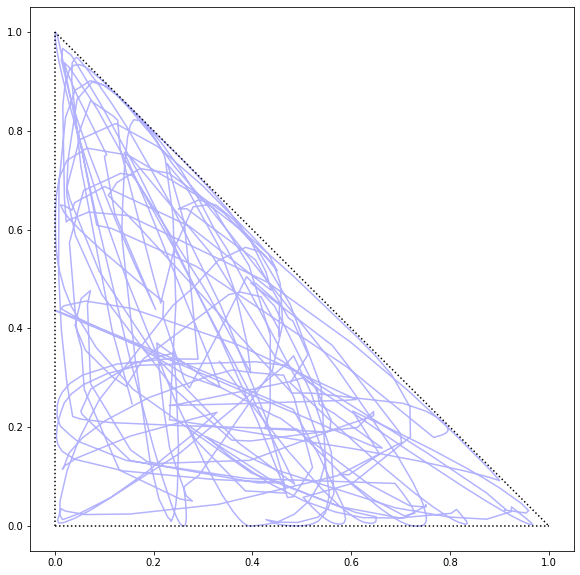

<Figure size 432x288 with 0 Axes>

In [6]:
# Riemannian metric HMC
reload(ms)

def g_inv(q):
    return pt.diag(q)-pt.outer(q,q)

def log_det_g_inv(q):
    return pt.sum(pt.log(q)) + pt.log(1-pt.sum(q))

def g_fun(q):
    r = b - A@q
    return A.T@pt.diag(1./r)@A


# Center the state
x_var = cvx.Variable(A.shape[1])

objective = cvx.Minimize(-cvx.sum(cvx.log(b-A@x_var)))
prob = cvx.Problem(objective=objective)
prob.solve()


x_var.value

q = pt.tensor(x_var.value,dtype=pt.float32)
p = pt.randn_like(q)

x = pt.cat([q,p]).detach().clone().requires_grad_(True)

NumSteps = 100

RHMC = ms.RHMCSampler(zeroLoss,g_inv)

X_list = []
Time_list = []


t = 0.

for step in tqdm(range(NumSteps)):
    #x = x + sigma * W[t]
    #x = projectPolyhedron(x,A,b)
    #
    X_traj,Time_traj = RHMC.step(x,tstart=t)
    x = X_traj[-1].detach().clone().requires_grad_(True)
    t = Time_traj[-1]
    X_list.append(X_traj)
    Time_list.append(Time_traj)
    
X = pt.cat(X_list,dim=0)
Time = pt.cat(Time_list)

X_np = X.detach().numpy()
plt.figure(figsize=(10,10))
plt.plot(X_np[:,0],X_np[:,1],'b',alpha=.3)


# Ordered Boundary
#plt.plot([1./3.,1./2.],[1./3.,1./2.],'k:')
#plt.plot([1./2.,1.],[1./2.,0.],'k:')
#plt.plot([1./3.,1.],[1./3.,0.],'k:')

# Unordered Boundary
plt.plot([0,1],[0,0],'k:')
plt.plot([0,0],[0,1],'k:')
plt.plot([0,1],[1,0],'k:')
plt.gca().set_aspect('equal')

plt.figure()
Alpha = np.hstack([X_np[:,:2],np.reshape(1-X_np[:,:2].sum(axis=1),(len(X_np),1))])
#Time = eta * np.arange(NumSteps+1)
#plt.plot(Time,np.cumsum(Alpha,axis=0)/np.outer(Time.detach().numpy()+1,np.ones(3)))

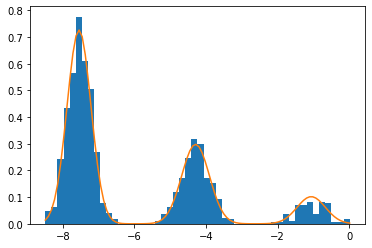

In [7]:
K = 3
n = 1000

def mixturePDF(x,mu,tau,alpha):
    p = pt.zeros_like(x)
    K = len(mu)
    for i in range(K):
        cur_dist = pt.distributions.Normal(mu[i],1/pt.sqrt(tau[i]))
        p = p + alpha[i] * pt.exp(cur_dist.log_prob(x))
        
    return p


p_dist = pt.distributions.Dirichlet(pt.ones(K))
p_unsorted = p_dist.sample()
sort_val = pt.sort(p_unsorted,descending=True)
p_true = sort_val.values

mu_L = -10
mu_U = 10
mu_dist = pt.distributions.Uniform(-10,10)
mu_true = mu_dist.sample((K,))

tau_L = 1./((mu_U-mu_L)**2)
tau_U = 10
tau_dist = pt.distributions.Uniform(5,10)
tau_true = tau_dist.sample((K,))

Category_dist = pt.distributions.Categorical(p_true)

Categories = Category_dist.sample((n,))

Means = mu_true[Categories]
Precisions = tau_true[Categories]

x = Means + pt.randn(n) / pt.sqrt(Precisions)

x_np = x.detach().numpy()
x_plot = pt.linspace(x.min(),x.max(),100)


p_plot = mixturePDF(x_plot,mu_true,tau_true,p_true)

plt.hist(x_np,bins=50,density=True)
plt.plot(x_plot,p_plot)


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]

tensor(-1268.0623) tensor(-1270.9838)
tensor([-4.2948, -7.5333, -1.0406])
tensor([6.4474, 8.6978, 5.4291])
tensor([0.2930, 0.6210, 0.0860])


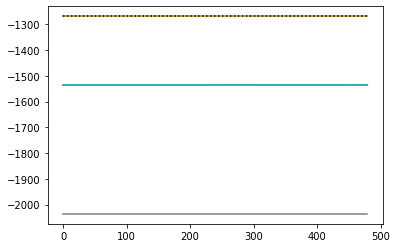

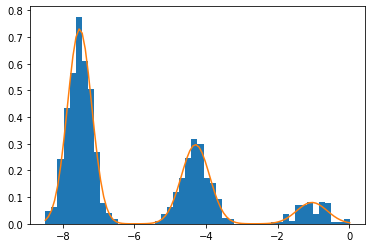

In [8]:
def EMStep(x,mu,tau,lam):
    n = len(x)
    K = len(lam)
    
    D = pt.outer(x,pt.ones_like(mu)) - pt.outer(pt.ones_like(x),mu)
    W = pt.exp(-.5  * D**2 @ pt.diag(tau)) @ pt.diag(pt.sqrt(tau)*lam)

    w = pt.diag(1/pt.sum(W,dim=1)) @ W 
    
    
    N = pt.sum(w,dim=0)
    
    lam_new = N/n
    
    
    mu_new = (x@w)/N
    
    
    
    D_new = pt.outer(x,pt.ones_like(mu)) - pt.outer(pt.ones_like(x),mu_new)
    tau_new = N / pt.sum(w*D_new**2,dim=0)

    
    return mu_new,tau_new,lam_new

def extractParameters(z):
    K = int((len(z)+1)/3)
    
    mu = z[:K]
    tau = z[K:2*K]
    alpha_var = z[2*K:]
    alpha_last = 1-pt.sum(alpha_var)
    alpha = pt.cat([alpha_var,alpha_last.view((1,))])
    alpha = pt.clamp(alpha,0.,1.)
    return mu,tau,alpha

def log_loss(x,z):
    n = len(x)
    
    mu,tau,alpha = extractParameters(z)
    D = pt.outer(x,pt.ones_like(mu)) - pt.outer(pt.ones_like(x),mu)
    M = -.5 * D**2 @ pt.diag(tau)+ \
        pt.outer(pt.ones_like(x),.5 * pt.log(tau)+pt.log(alpha))
    
    Likelihoods = pt.logsumexp(M,dim=1)
    return -pt.sum(Likelihoods)

def loglikelihood(x,mu,tau,lam):
    z = pt.cat([mu,tau,lam[:-1]])
    return -log_loss(x,z) - (len(x)/2.) * np.log(2*np.pi) 
    
    
NumRuns = 20
NumSteps = 500

BestEM = -pt.tensor(np.inf)
TrueLL = loglikelihood(x,mu_true,tau_true,p_true)

for run in tqdm(range(NumRuns)):
    
    finalLikelihood = pt.tensor(np.nan)
    while pt.isnan(finalLikelihood):
        mu = mu_dist.sample((K,))
        tau = tau_dist.sample((K,))
        lam = p_dist.sample()


        
        Likelihoods = []

        for _ in range(NumSteps):
    
            mu,tau,lam = EMStep(x,mu,tau,lam)
    
            
            like = loglikelihood(x,mu,tau,lam)
            
            if pt.isnan(like):
                break
                
            else:
                Likelihoods.append(like)
                
                
        finalLikelihood = like
        
    if like > BestEM:
        BestEM = like
        mu_best = mu
        tau_best = tau
        lam_best = lam
    LLPlot = Likelihoods[20:]
    plt.plot(LLPlot)
       
print(BestEM,TrueLL)
print(mu_best)
print(tau_best)
print(lam_best)
plt.plot([0,len(LLPlot)-1],[BestEM,BestEM],'k:')

plt.figure()
plt.hist(x_np,bins=50,density=True)
plt.plot(x_plot,mixturePDF(x_plot,mu_best,tau_best,lam_best))

In [9]:
A_mu = pt.kron(pt.eye(K),pt.tensor([[-1.],
                                    [1.]]))
b_mu = pt.kron(pt.ones(K),pt.tensor([-mu_L,mu_U]))

A_tau = A_mu.clone()
b_tau = pt.kron(pt.ones(K),pt.tensor([-tau_L,tau_U]))

#b_alpha = pt.cat([pt.zeros(K-2),pt.tensor([-1.,1.])])
#A_alpha = pt.cat([-pt.eye(K-1)+pt.diag(pt.ones(K-2),1),
#                  pt.zeros((1,K-1))]) + \
#          pt.outer(b_alpha,pt.ones(K-1))

A_alpha = pt.cat([-pt.eye(K-1),pt.ones((1,K-1))],dim=0)
slack = 1e-4
b_alpha = pt.cat([-slack*pt.ones(K-1),pt.ones(1)*(1-slack)])

A = pt.block_diag(A_mu,A_tau,A_alpha)
b = pt.cat([b_mu,b_tau,b_alpha])
NumConstraints,NumVars = A.shape 

z = pt.randn(NumVars)




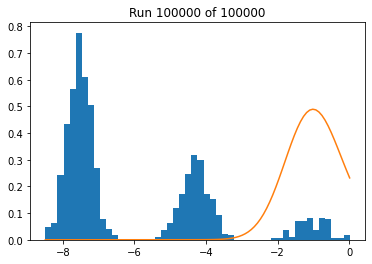

100%|██████████| 100000/100000 [03:28<00:00, 480.43it/s]


tensor([-1.1399, -3.5197, -0.5902], grad_fn=<SliceBackward>) tensor([1.9352, 0.1254, 1.2720], grad_fn=<SliceBackward>) tensor([0.2283, 0.6940, 0.0777], grad_fn=<ClampBackward1>)


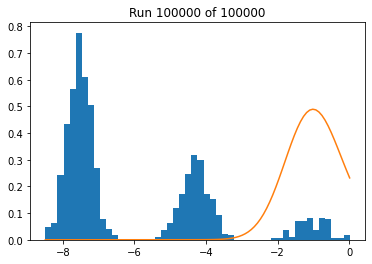

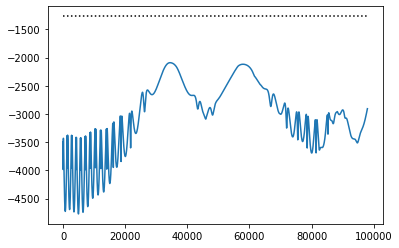

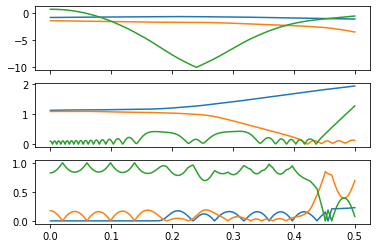

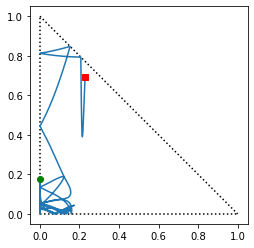

In [10]:
# SO Langevin
from IPython import display
import time
reload(ms)
z = pt.randn(2*NumVars)
z = ms.reflectPolyhedron(z,A,b)



#z = pt.cat([mu_dist.sample((K,)),
#            tau_L * pt.ones(K),
#            pt.ones(K-1)/K]) 
z = z.detach().clone().requires_grad_(True)

Loss = log_loss(x,z[:NumVars])


loss_x = lambda z : log_loss(x,z[:NumVars])
eta = 5e-6

SOSampler = ms.SOLangevin(loss_x,eta,A=A,b=b)
mu,tau,alpha = extractParameters(z[:NumVars])
LogLike = loglikelihood(x,mu,tau,alpha)
NumSteps = int(1e4)


Z = [z]
Likelihoods=[LogLike]

plt.figure()

for step in tqdm(range(NumSteps)):
    #if step < 10000:
    #    loss = zeroLoss
    #else:
    #    loss = loss_x
    #z = FOLangevinStep(z,loss_x,eta=eta,beta=1,A=A,b=b)
    
    z = SOSampler.step(z)
    Z.append(z.detach().clone())
    mu,tau,alpha = extractParameters(z[:NumVars])
    LogLike = loglikelihood(x,mu,tau,alpha)
    if pt.isnan(LogLike):
        print(mu)
        print(tau)
        print(alpha)
        break
        
    if LogLike > BestEM:
        print(mu)
        print(tau)
        print(alpha)
        break
        
    Likelihoods.append(LogLike)
    
    if ((step+1) % 1000) == 0:

        
        plt.clf()
        plt.hist(x_np,bins=50,density=True)
        plt.plot(x_plot,mixturePDF(x_plot,mu,tau,lam).detach().numpy())
        plt.title('Run %d of %d' % (step+1,NumSteps))
        
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.5)
        
        
        
plt.figure()
LLPlot = Likelihoods[2000:]
plt.plot([0,len(LLPlot)-1],[BestEM,BestEM],'k:')
plt.plot(LLPlot)

print(mu,tau,alpha)

Z = pt.stack(Z)
Z_np = Z.detach().numpy()
Time = eta * np.arange(len(Z_np))
Mu = Z_np[:,:K]
Tau = Z_np[:,K:2*K]
Alpha = np.hstack([Z_np[:,2*K:NumVars],(1-np.sum(Z_np[:,2*K:NumVars],axis=1)).reshape((len(Z_np),1))])

fig,ax = plt.subplots(3,1,sharex=True)
ax[0].plot(Time,Mu)
ax[1].plot(Time,Tau)
ax[2].plot(Time,Alpha)

plt.figure()
plt.plot([slack,1-2*slack],[slack,slack],'k:')
plt.plot([slack,slack],[slack,1-2*slack],'k:')
plt.plot([slack,1-2*slack],[1-2*slack,slack],'k:')
plt.plot(Alpha[:,0],Alpha[:,1])
plt.plot(Alpha[0,0],Alpha[0,1],'go')
plt.plot(Alpha[-1,0],Alpha[-1,1],'rs')
plt.gca().set_aspect('equal')


In [11]:
z.shape

torch.Size([16])

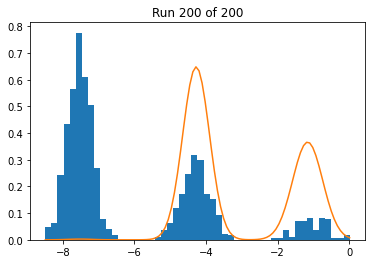

100%|██████████| 200/200 [04:36<00:00,  1.38s/it]


tensor([-4.2773, -7.5183, -1.1603], grad_fn=<SliceBackward>) tensor([7.0761, 8.5867, 5.6311], grad_fn=<SliceBackward>) tensor([0.2234, 0.6941, 0.0825], grad_fn=<ClampBackward1>)


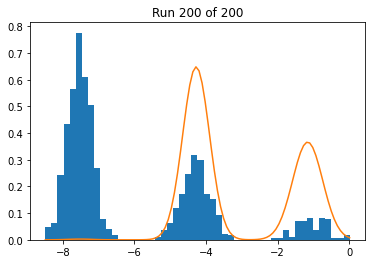

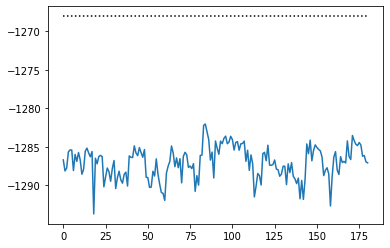

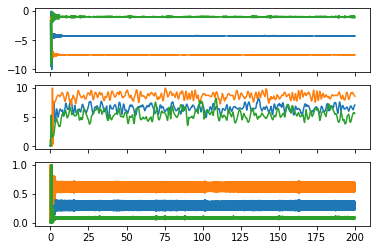

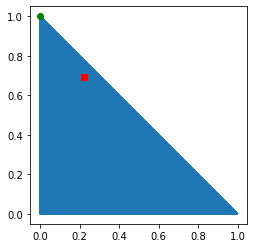

In [12]:
# HMC
reload(ms)
from IPython import display
import time
z = pt.randn(2*NumVars)
z = ms.reflectPolyhedron(z,A,b)

HMCSampler = ms.HMCSampler(loss_x,A,b)


#z = pt.cat([mu_dist.sample((K,)),
#            tau_L * pt.ones(K),
#            pt.ones(K-1)/K]) 
z = z.detach().clone().requires_grad_(True)
Loss = log_loss(x,z[:NumVars])
mu,tau,alpha = extractParameters(z[:NumVars])
LogLike = loglikelihood(x,mu,tau,alpha)
NumSteps = int(200)

Z_list = []
Time_list = []
Likelihoods=[LogLike]

plt.figure()

loss_x = lambda z : log_loss(x,z[:NumVars])
t = 0
for step in tqdm(range(NumSteps)):
    #if step < 10000:
    #    loss = zeroLoss
    #else:
    #    loss = loss_x
    #z = FOLangevinStep(z,loss_x,eta=eta,beta=1,A=A,b=b)
    
    Z_traj,Time_traj = HMCSampler.step(z,tstart=t)
    Z_list.append(Z_traj)
    Time_list.append(Time_traj)
    z = Z_traj[-1].detach().clone().requires_grad_(True)
    t = Time_traj[-1]
    mu,tau,alpha = extractParameters(z[:NumVars])
    LogLike = loglikelihood(x,mu,tau,alpha)
    if pt.isnan(LogLike):
        print(mu)
        print(tau)
        print(alpha)
        break
        
    if LogLike > BestEM:
        print(mu)
        print(tau)
        print(alpha)
        break
        
    Likelihoods.append(LogLike)
    
    if ((step+1) % 10) == 0:

        
        plt.clf()
        plt.hist(x_np,bins=50,density=True)
        plt.plot(x_plot,mixturePDF(x_plot,mu,tau,lam).detach().numpy())
        plt.title('Run %d of %d' % (step+1,NumSteps))
        
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.5)
        
        
        
plt.figure()
LLPlot = Likelihoods[int(NumSteps/10):]
plt.plot([0,len(LLPlot)-1],[BestEM,BestEM],'k:')
plt.plot(LLPlot)

print(mu,tau,alpha)

Z = pt.cat(Z_list,dim=0)
Z_np = Z.detach().numpy()
Time = pt.cat(Time_list)
Mu = Z_np[:,:K]
Tau = Z_np[:,K:2*K]
Alpha = np.hstack([Z_np[:,2*K:NumVars],(1-np.sum(Z_np[:,2*K:NumVars],axis=1)).reshape((len(Z_np),1))])

fig,ax = plt.subplots(3,1,sharex=True)
ax[0].plot(Time,Mu)
ax[1].plot(Time,Tau)
ax[2].plot(Time,Alpha)

plt.figure()
plt.plot([slack,1-2*slack],[slack,slack],'k:')
plt.plot([slack,slack],[slack,1-2*slack],'k:')
plt.plot([slack,1-2*slack],[1-2*slack,slack],'k:')
plt.plot(Alpha[:,0],Alpha[:,1])
plt.plot(Alpha[0,0],Alpha[0,1],'go')
plt.plot(Alpha[-1,0],Alpha[-1,1],'rs')
plt.gca().set_aspect('equal')